# Analysing BPMD simulations

In this notebook, we'll walk through a simple example of how to open and plot the time-wise BPMD scores, take their averages over multiple replicas and determining the final stability score for the given pose.

First, we import a few modules.

In [3]:
import os
import glob
import numpy as np
import pandas as pd
# temp fix before the scripts are in the python path
import sys
sys.path.append("../openbpmd")
from analysis import *

Let's start by looking at one replica.

In [4]:
f = os.path.join('stable_pose','rep_0','bpm_results.csv')
df = pd.read_csv(f)
df

,CompScore,PoseScore,ContactScore
0,-3.996052,1.003948,1.000000
1,-3.355862,0.929852,0.857143
2,-3.415540,0.870175,0.857143
3,-3.361103,0.924611,0.857143
4,-3.512704,0.773010,0.857143
...,...,...,...
94,-1.328399,0.814459,0.428571
95,-1.132346,1.010511,0.428571
96,-3.394253,0.891461,0.857143
97,-2.969395,1.316319,0.857143


As you can see the different scores were calculated for each frame. Let's plot each of the scores for this replica.

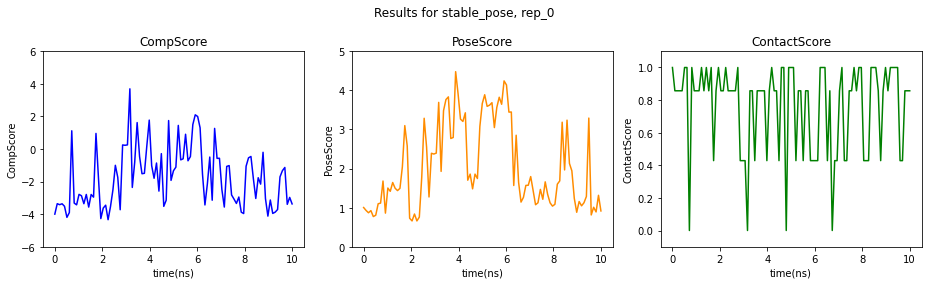

In [5]:
single_rep_plot(f)

As you can see, the scores are very noisy. This is typical of short metadynamics simulations that haven't yet converged the free energy surface. However, we're not interested in the free energy. We're only want to test the stability of the ligand in the binding pose. 

To have more confidence in the stability scores, we run multiple repeat simulations. In reporting the final PoseScore and ContactScore, after 10 repeats, we take the mean of the score over the last 2 ns, which also helps with the noise.

Let's see what the mean of the scores looks when average-out over time.

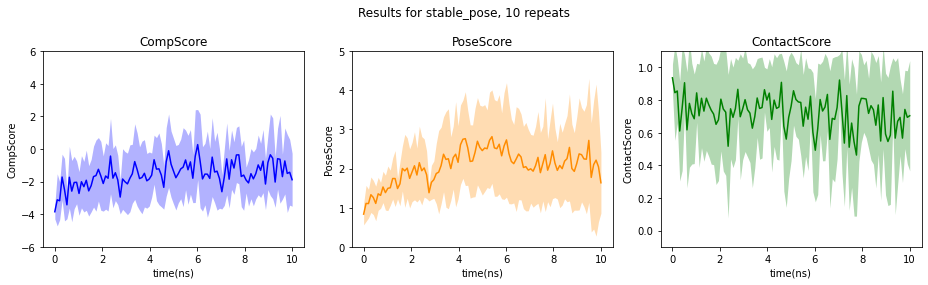

In [6]:
plot_all_reps('stable_pose')

# if you want to save the plot, specify the location and the name of the file
# plot_all_reps('stable_pose', save_fig='stable_pose_plot.png')

Much better. You can now see how averaging multiple repeats reduces the noise of the scores. 

In the case of a large stability screen, we want to automate things. In order to get a single number that evaluates a given pose/ligand, we take the scores of the final 2 ns.

In [7]:
compList = []
contactList = []
poseList = []
# Find how many repeats have been run
glob_str = os.path.join('stable_pose','rep_*')
nreps = len(glob.glob(glob_str))
for idx in range(0, nreps):
    f = os.path.join('stable_pose',f'rep_{idx}','bpm_results.csv')
    df = pd.read_csv(f)
    # Since we only want last 2 ns, get the index of
    # the last 20% of the data points
    last_2ns_idx = round(len(df['CompScore'].values)/5)  # round up
    compList.append(df['CompScore'].values[-last_2ns_idx:])
    contactList.append(df['ContactScore'].values[-last_2ns_idx:])
    poseList.append(df['PoseScore'].values[-last_2ns_idx:])

# Get the means of the last 2 ns
meanCompScore = np.mean(compList)
meanPoseScore = np.mean(poseList)
meanContact = np.mean(contactList)
# Get the standard deviation of the final 2 ns
meanCompScore_std = np.std(compList)
meanPoseScore_std = np.std(poseList)
meanContact_std = np.std(contactList)
# Format it the Pandas way
d = {'CompScore': [meanCompScore], 'CompScoreSD': [meanCompScore_std],
     'PoseScore': [meanPoseScore], 'PoseScoreSD': [meanPoseScore_std],
     'ContactScore': [meanContact], 'ContactScoreSD': [meanContact_std]}

results_df = pd.DataFrame(data=d)
results_df = results_df.round(3)

results_df

,CompScore,CompScoreSD,PoseScore,PoseScoreSD,ContactScore,ContactScoreSD
0,-1.314,1.946,2.146,1.278,0.692,0.339


The snippet of code above is taken directly from the ```collect_results()``` function in the ```openbpmd.py``` script and you should see the ```results.csv``` file in the ```output``` directory.

## Unstable pose comparison

To better understand what the results look like for an unstable pose of the same ligand, I included another run of OpenBPMD simulations.

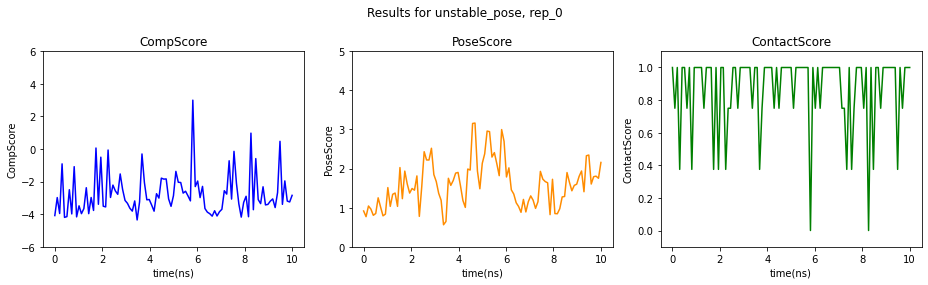

In [8]:
f = os.path.join('unstable_pose','rep_0','bpm_results.csv')
df = pd.read_csv(f)
single_rep_plot(f)

Odd, that looks pretty stable, right? Let's look at a few more repeats, individually.

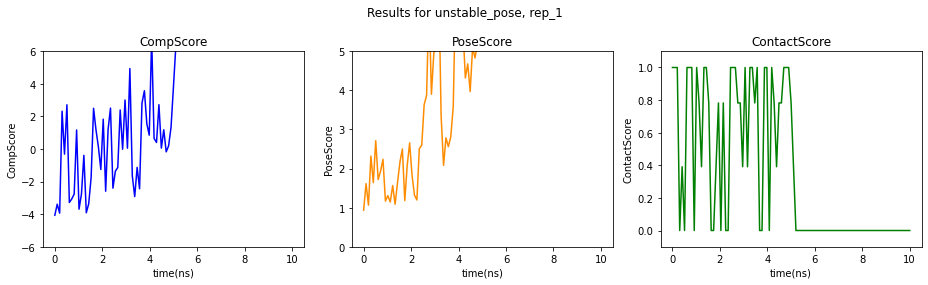

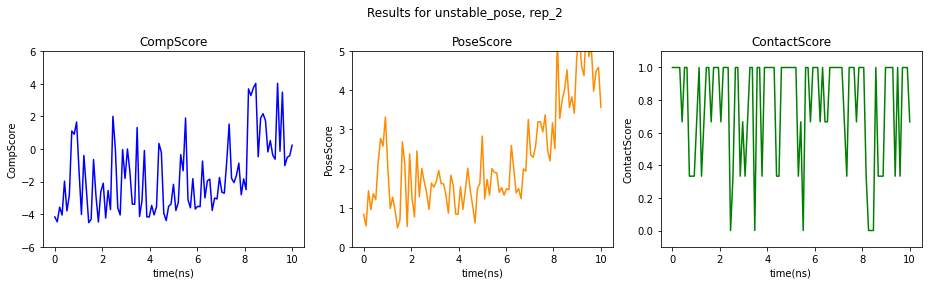

In [9]:
for i in range(1,3):
    f = os.path.join('unstable_pose',f'rep_{i}','bpm_results.csv')
    df = pd.read_csv(f)
    single_rep_plot(f)

Now you can very clearly see that other repeat simulations show the ligand unbinding, like in rep_1, or significantly shifting in the binding site, like rep_2.

This is what an average of 10 BPMD simulations looks like:

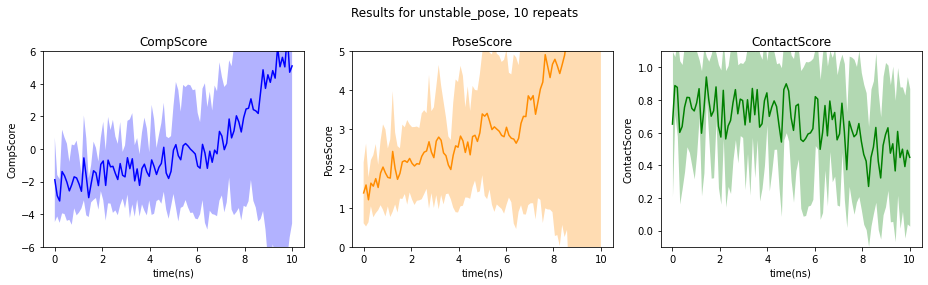

In [10]:
plot_all_reps('unstable_pose')

A few words of advice on making sense of BPMD results:
1. The lower (more negative) the CompScore, the more likely a given pose to be the correct pose. 'Correct' here means a binding pose that is similar to a pose observed in an experimentally determined structure. 
2. PoseScore, being an arguably more objective measure than ContactScore, should be given a slighlty higher weight when the CompScores of two poses are very similar.
3. The standard deviations of the scores might seem really high when compared to the scores themselves. Short metadynamics simulations are known to be very noisy, so this is expected. In my experience, poses with lower SD also tend to be have a lower RMSD to the experimentally known pose. Therefore, SD is a useful indicator of confidence.
4. CompScores should only be compared between poses of the same ligand, not for comparing stability of different ligands. We haven't investigated the correlation between the CompScore of single pose of a ligand and its potency yet.